Not running on Google Colab. Skipping drive mount.
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START classifier__n_estimators=50.................................
[CV 1/3; 1/5] END ..classifier__n_estimators=50;, score=0.809 total time=  27.5s
[CV 2/3; 4/5] START classifier__n_estimators=125................................
[CV 2/3; 4/5] END .classifier__n_estimators=125;, score=0.812 total time=  49.0s
[CV 2/3; 1/5] START classifier__n_estimators=50.................................
[CV 2/3; 1/5] END ..classifier__n_estimators=50;, score=0.808 total time=  28.4s
[CV 3/3; 4/5] START classifier__n_estimators=125................................
[CV 3/3; 4/5] END .classifier__n_estimators=125;, score=0.814 total time=  48.6s
[CV 3/3; 1/5] START classifier__n_estimators=50.................................
[CV 3/3; 1/5] END ..classifier__n_estimators=50;, score=0.810 total time=  28.5s
[CV 1/3; 5/5] START classifier__n_estimators=150...............................

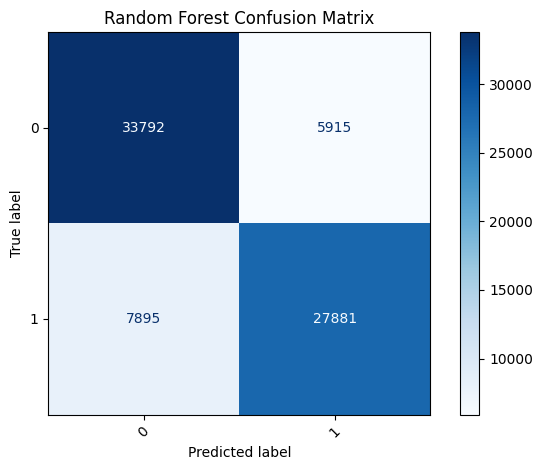

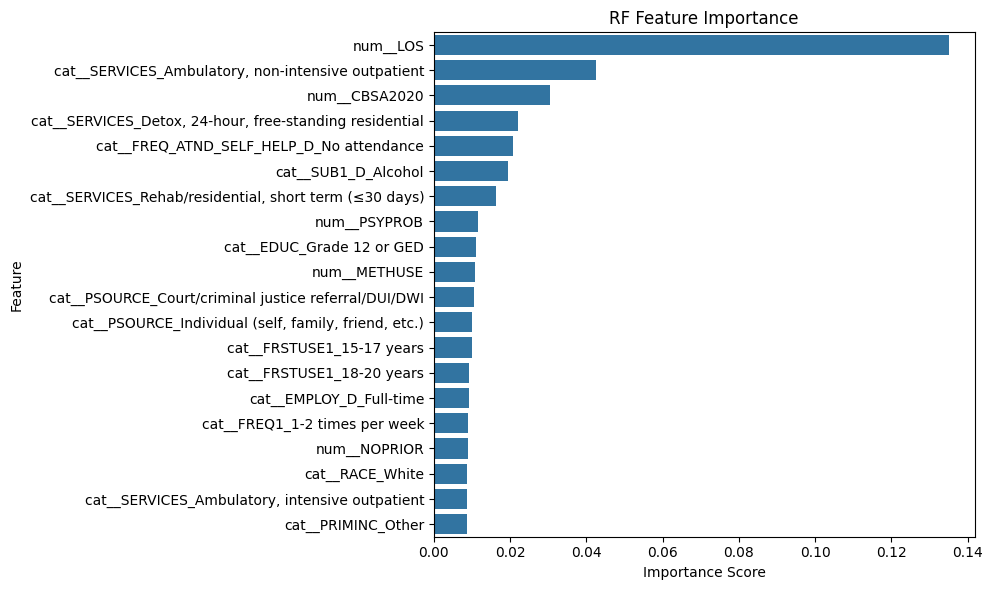

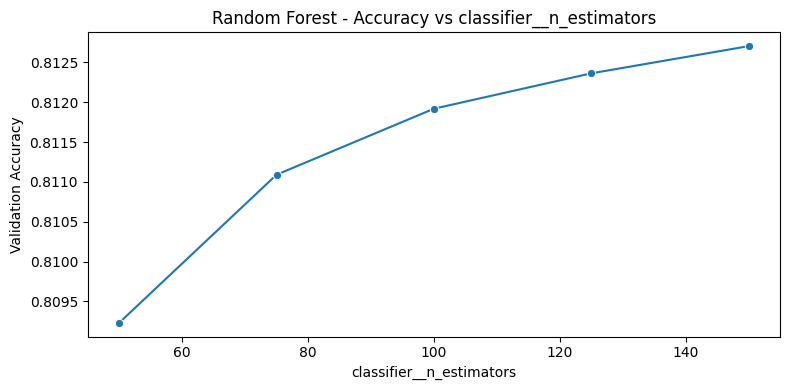

Train Accuracy RF: 0.9991786121194457
Test Accuracy RF: 0.8170448975265954
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78     39707
           1       0.75      0.77      0.76     35776

    accuracy                           0.77     75483
   macro avg       0.77      0.77      0.77     75483
weighted avg       0.77      0.77      0.77     75483



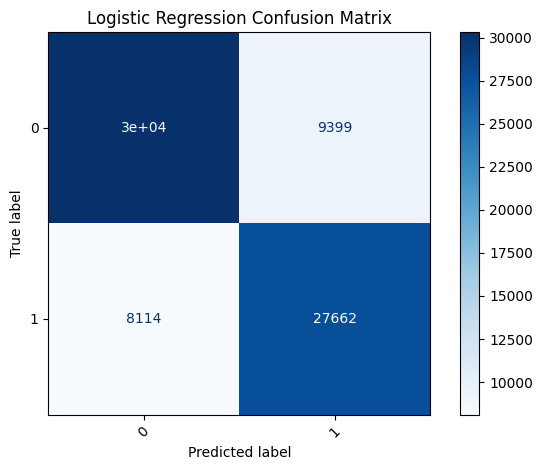

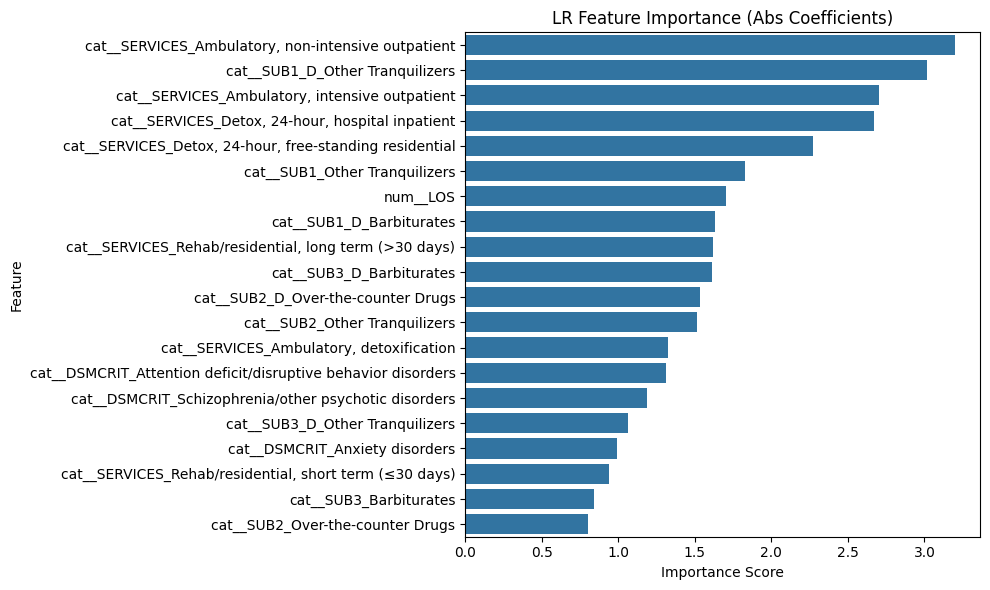

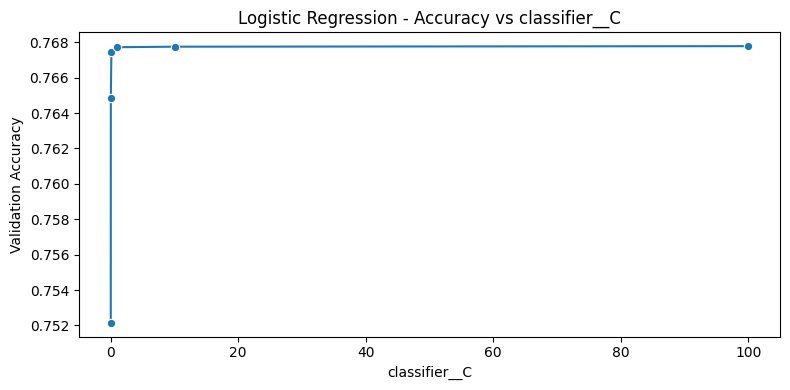

Fitting 3 folds for each of 5 candidates, totalling 15 fits
HistGradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     39707
           1       0.82      0.79      0.80     35776

    accuracy                           0.82     75483
   macro avg       0.82      0.82      0.82     75483
weighted avg       0.82      0.82      0.82     75483



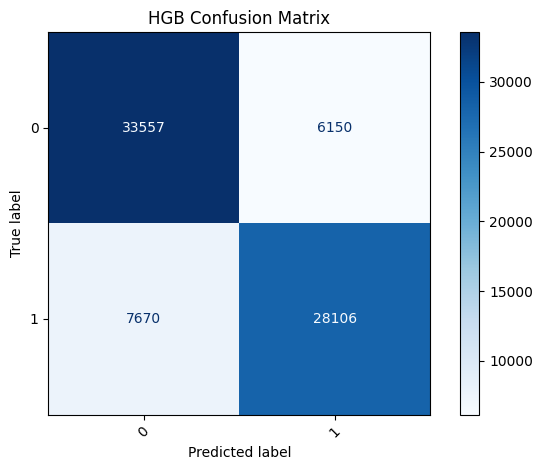

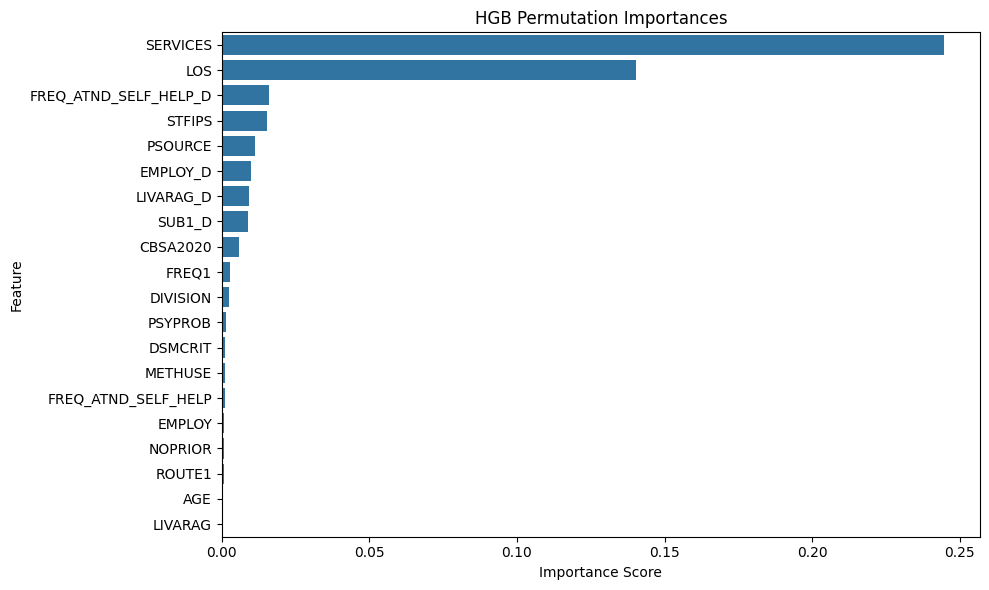

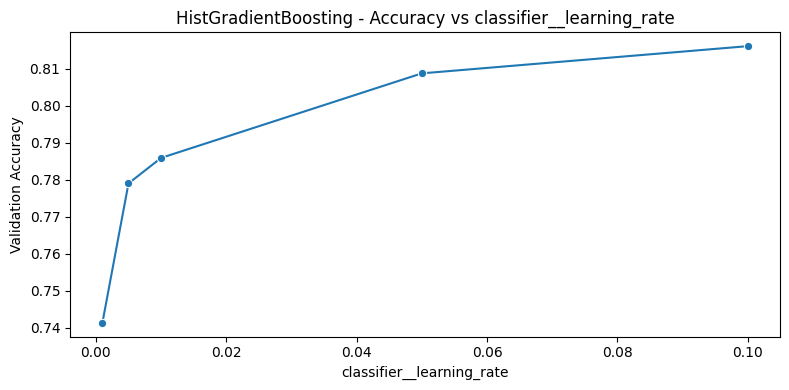

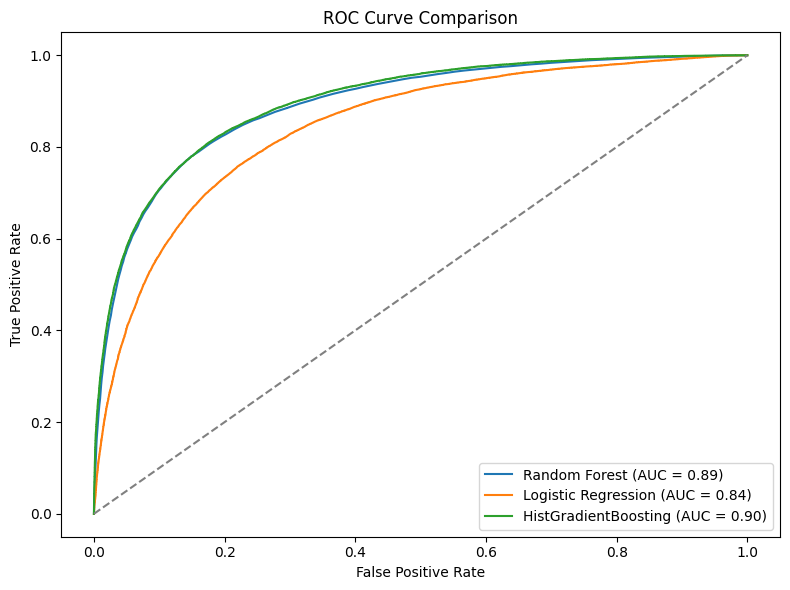

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import os

try:
    from google.colab import drive
    drive.mount('/content/drive')
    df_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_clean_export.csv')
except ModuleNotFoundError:
    print("Not running on Google Colab. Skipping drive mount.")
    try:
        df_clean = pd.read_csv('./DAAN881/df_clean_export.csv')
    except FileNotFoundError:
        print("Local file not found. Check the path!")
        print("Current directory:", os.getcwd())
        print("Files here:", os.listdir())


# === 1. SPLIT AND ENCODE ===
df_clean['completed_binary'] = df_clean['REASON'].map({'Yes': 1, 'No': 0})
y = df_clean['completed_binary']

num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.drop(['completed_binary', 'CASEID']).tolist()
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.drop(['REASON']).tolist()

# Define the predictors and target
X = df_clean[num_cols + cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Numeric pipeline: impute using median and scale features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute using the most frequent value and one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Build Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Build Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# === 2. MODEL TUNING & EVALUATION HELPERS ===
def plot_conf_matrix(y_true, y_pred, labels, title, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap=cmap)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances, title):
    top = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top, y=top.index)
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

def plot_cv_results(cv_results, param_name, title):
    scores = pd.DataFrame(cv_results)
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=scores[f"param_{param_name}"], y=scores['mean_test_score'], marker='o')
    plt.title(f"{title} - Accuracy vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Validation Accuracy")
    plt.tight_layout()
    plt.show()

# === 3. RANDOM FOREST ===
param_rf = {'classifier__n_estimators': [ 50, 75, 100, 125, 150]}
grid_rf = GridSearchCV(rf_pipeline, param_rf, cv=3, scoring='accuracy', verbose=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
plot_conf_matrix(y_test, y_pred_rf, best_rf.named_steps['classifier'].classes_, "Random Forest Confusion Matrix")

# Feature Importance from model
rf_feat_imp = pd.Series(
    best_rf.named_steps['classifier'].feature_importances_,
    index=best_rf.named_steps['preprocessor'].get_feature_names_out()
)
plot_feature_importance(rf_feat_imp, "RF Feature Importance")
plot_cv_results(grid_rf.cv_results_, "classifier__n_estimators", "Random Forest")

print("Train Accuracy RF:", best_rf.score(X_train, y_train))
print("Test Accuracy RF:", best_rf.score(X_test, y_test))

# === 4. LOGISTIC REGRESSION ===
param_lr = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(lr_pipeline, param_lr, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
plot_conf_matrix(y_test, y_pred_lr, best_lr.named_steps['classifier'].classes_, "Logistic Regression Confusion Matrix")

lr_feat_imp = pd.Series(
    best_lr.named_steps['classifier'].coef_[0],
    index=best_lr.named_steps['preprocessor'].get_feature_names_out()
).abs()
plot_feature_importance(lr_feat_imp, "LR Feature Importance (Abs Coefficients)")

plot_cv_results(grid_lr.cv_results_, "classifier__C", "Logistic Regression")
# === 5. HISTGRADIENTBOOSTING ===
param_hgb = {'classifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]}
hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

grid_hgb = GridSearchCV(hgb_pipeline, param_hgb, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
grid_hgb.fit(X_train, y_train)

best_hgb = grid_hgb.best_estimator_
y_pred_hgb = best_hgb.predict(X_test)

print("HistGradientBoostingClassifier:")
print(classification_report(y_test, y_pred_hgb))
plot_conf_matrix(y_test, y_pred_hgb, best_hgb.named_steps['classifier'].classes_, "HGB Confusion Matrix")

perm_importance = permutation_importance(
    best_hgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
plot_feature_importance(pd.Series(perm_importance.importances_mean, index=X.columns), "HGB Permutation Importances")

plot_cv_results(grid_hgb.cv_results_, "classifier__learning_rate", "HistGradientBoosting")

def plot_roc_curves(models, model_names, X_test_list, y_test, positive_label=1):
    plt.figure(figsize=(8, 6))

    for model, name, X_test_ in zip(models, model_names, X_test_list):
        y_prob = model.predict_proba(X_test_)[:, model.named_steps['classifier'].classes_ == positive_label].flatten()
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=positive_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


# List of models & settings
models = [best_rf, best_lr, best_hgb]
model_names = ['Random Forest', 'Logistic Regression', 'HistGradientBoosting']
X_test_list = [X_test, X_test, X_test]

plot_roc_curves(models, model_names, X_test_list, y_test)
